In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import os
import sys
import re
import sys

import fna
import warnings

warnings.filterwarnings('ignore') # warnings are for the weak

sys.path.append("../../demyelination/") # we need this to successfully read pickle files
sys.path.append("../") # we need this to successfully read pickle files
sys.path.append("../../") # we need this to successfully read pickle files

import pipeline as pipeline


In [10]:
def gatherSpikes(path, filename, nthreads, brainPart, neuronIdFirst, neuronIdLast):
    '''
    Example Usage: 
    gatherSpikes("demyelination/data/adaptation-aone-plast/activity/", \
                 "spk_adaptation-aone-plast_T=0_nuX_aone=20.0_gamma_aone=9.0_w_input_aone=15.0_", \
                 2, "iA1", 2001, 2500)
    '''
    
    spikes = {}
    files = {}
    
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))
    
    for neuron in range(neuronIdFirst, neuronIdLast+1):
        rthread = neuron % nthreads
        files[0].spikeobj[brainPart].spiketrains[neuron] = files[rthread].spikeobj[brainPart].spiketrains[neuron]
    
    return files[0].spikeobj[brainPart]

# def gatherConnectivity(path, filename, nthreads, brainPart, DenType):
#     files = {}
#     # read files
#     for threadid in range(nthreads):
#         files[threadid] = pd.read_pickle(path + filename + str(threadid))

#     conn = np.sum([files[x].connectivity['z_connected']['Den'][DenType][brainPart] for x in range(nthreads)], axis=0)
    
#     return conn

def gatherConnectivity(path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    for var in ["z", "z_connected"]:
        for synElem in ["Axon", "Den"]:
            for synElemType in ["ex", "in"]:
                for brainPart in ["eA1", "iA1"]:
                    files[0].connectivity[var][synElem][synElemType][brainPart] = \
                    np.sum([files[x].connectivity[var][synElem][synElemType][brainPart] for x in range(nthreads)], axis=0)
    
    return files[0].connectivity

def gatherNestConnectivity(path, filename, nthreads, source, target):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    conn = np.sum([files[x].nestconnectivity[source][target] for x in range(nthreads)], axis=0)
    
    return conn

def gatherCalcium (path, filename, nthreads):
    files = {}
    # read files
    for threadid in range(nthreads):
        files[threadid] = pd.read_pickle(path + filename + str(threadid))

    calc = {}
    for source in ['eA1', 'MGN']:
        calc.update( {source : np.mean([files[x].calcium[source] for x in range(nthreads)], axis=0)} )
    
    return calc

** pyspike ** package is not installed. To have functions using pyspike please install the package.
** pyspike ** package is not installed. To have functions using pyspike please install the package.
** mayavi.mlab ** package is not installed. To have functions using mayavi.mlab please install the package.
** mnist.loader ** package is not installed. To have functions using mnist.loader please install the package.
** tables ** package is not installed. To have functions using tables please install the package.


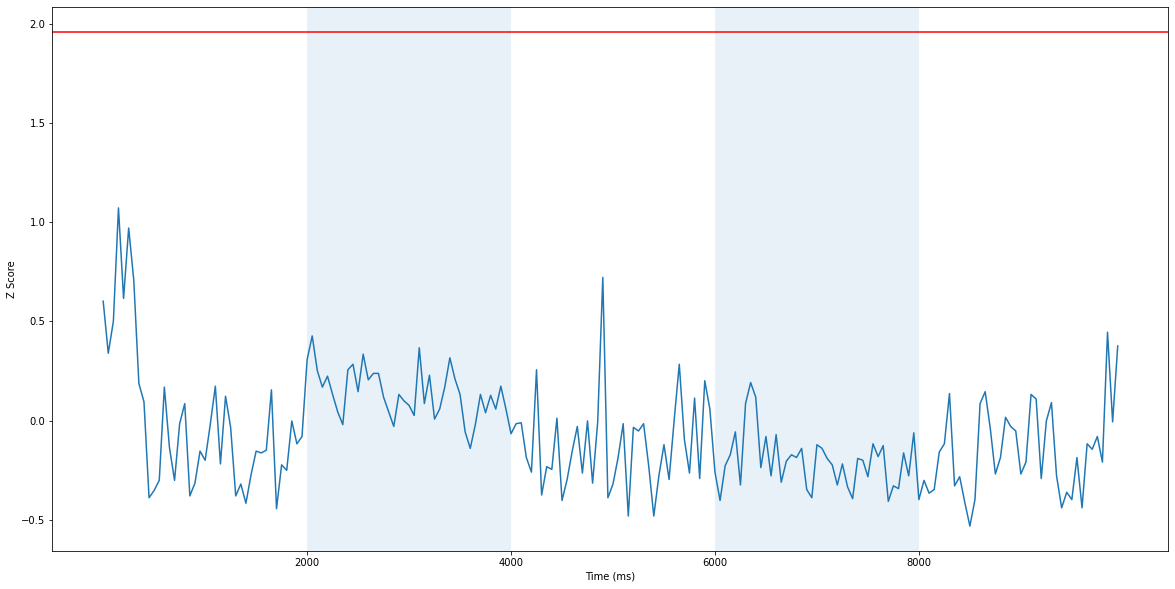

In [3]:
pth = "../../demyelination/data/dual-stim/activity/"
f = ['spk_dual-stim_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801))

baseline_tstart, baseline_tstop = 0, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 50

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 10)

ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1);
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1);

ax.plot(z_scores)

ax.set_xticks([40, 80, 120, 160], [2000, 4000, 6000, 8000]);

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");

In [41]:
for population in ['MGN', 'TRN', 'eA1', 'iA1']:
    for criterion in ['cerina', 'mit']:
        spk_train = p.spikeobj[population].time_slice(1000, 2000)
        br = pipeline.computePopulationBurstSpikeRatio(spk_train, criterion)
        print(population, criterion, np.mean(br))

MGN cerina 5.148674242424242
MGN mit 10.51578490953491
TRN cerina 6.814981546231547
TRN mit 16.299033605283608
eA1 cerina 5.771522805667903
eA1 mit 8.97397518781853
iA1 cerina 10.45442625212587
iA1 mit 14.126426538480017


## Step Current Instead of Poisson Generator

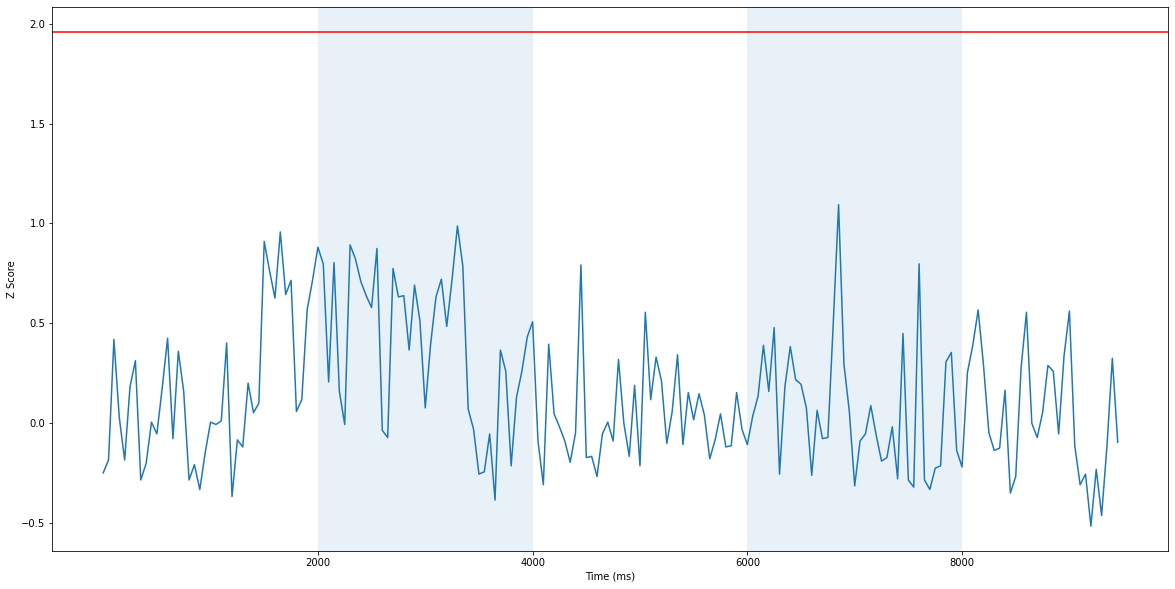

In [226]:
pth = "../../demyelination/data/dual-stim-stepcurr/activity/"
f = ['spk_dual-stim-stepcurr_T=0']
p = pd.read_pickle(pth + f[0])

stim_neurons = p.spikeobj['eA1'].id_slice(range(401, 801)).time_slice(500, 10000)

baseline_tstart, baseline_tstop = 501, 2000
baseline_firing_rate = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate()
firing_rate_sd = stim_neurons.time_slice(baseline_tstart, baseline_tstop).mean_rate_std()

first_stim_start = 2000
first_stim_end = 4000

second_stim_start = 6000
second_stim_end = 8000

time_bin = 50

mfr = np.mean(stim_neurons.firing_rate(time_bin), axis=0)

z_scores = (mfr - baseline_firing_rate) / firing_rate_sd

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(20, 10)

ax.axhline(1.96, color='r');

first_stim_start_marker = first_stim_start / time_bin
first_stim_end_marker = first_stim_end / time_bin

second_stim_start_marker = second_stim_start / time_bin
second_stim_end_marker = second_stim_end / time_bin

ax.axvspan(first_stim_start_marker, first_stim_end_marker, alpha=.1);
ax.axvspan(second_stim_start_marker, second_stim_end_marker, alpha=.1);

ax.plot(z_scores)

ax.set_xticks([40, 80, 120, 160], [2000, 4000, 6000, 8000]);

ax.set_xlabel("Time (ms)");
ax.set_ylabel("Z Score");